In [1]:
# 📦 1. Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [6]:
# 📁 2. Load Dataset (Assume PlantVillage-style)
dataset_path = "../data/PlantVillage"  # Should contain 15 class folders
img_size = (224, 224)
batch_size = 32

dataset = image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

class_names = dataset.class_names
num_classes = len(class_names)

Found 20638 files belonging to 15 classes.


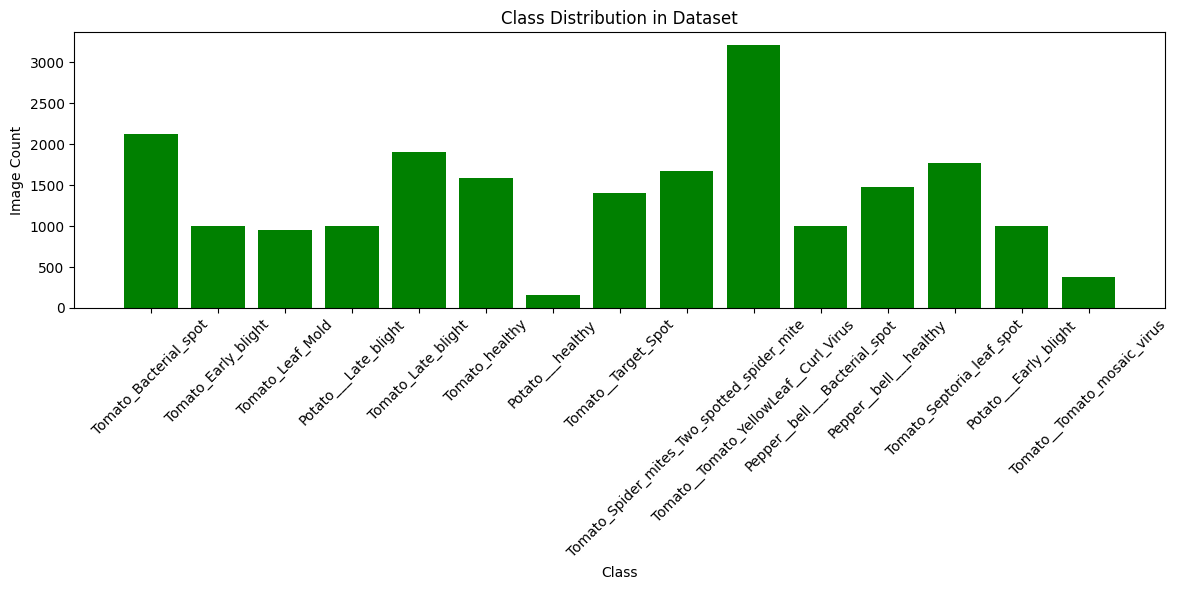

In [7]:
# 👀 3. Visualize Class Distribution
label_counts = {}
for _, labels in dataset:
    for label in labels.numpy():
        label_counts[class_names[label]] = label_counts.get(class_names[label], 0) + 1

plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='green')
plt.xticks(rotation=45)
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

In [8]:
# ⚙️ 4. Extract Features using ResNet50 (as a frozen feature extractor)
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
resnet.trainable = False

X = []
y = []

for images, labels in dataset:
    preprocessed = preprocess_input(images)
    features = resnet(preprocessed).numpy()
    X.append(features)
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

In [9]:
# 🔀 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# 🤖 6. Train KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'euclidean'
,metric_params,None
,n_jobs,None


In [11]:
# 📊 7. Evaluate Model
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.9377422480620154
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.96      0.98       199
                     Pepper__bell___healthy       0.97      1.00      0.99       296
                      Potato___Early_blight       0.97      0.99      0.98       200
                       Potato___Late_blight       0.96      0.95      0.96       200
                           Potato___healthy       0.94      0.97      0.95        30
                      Tomato_Bacterial_spot       0.94      0.99      0.96       426
                        Tomato_Early_blight       0.97      0.70      0.82       200
                         Tomato_Late_blight       0.97      0.92      0.94       382
                           Tomato_Leaf_Mold       0.93      0.93      0.93       190
                  Tomato_Septoria_leaf_spot       0.91      0.93      0.92       354
Tomato_Spider_mites_Two_spotted_spi

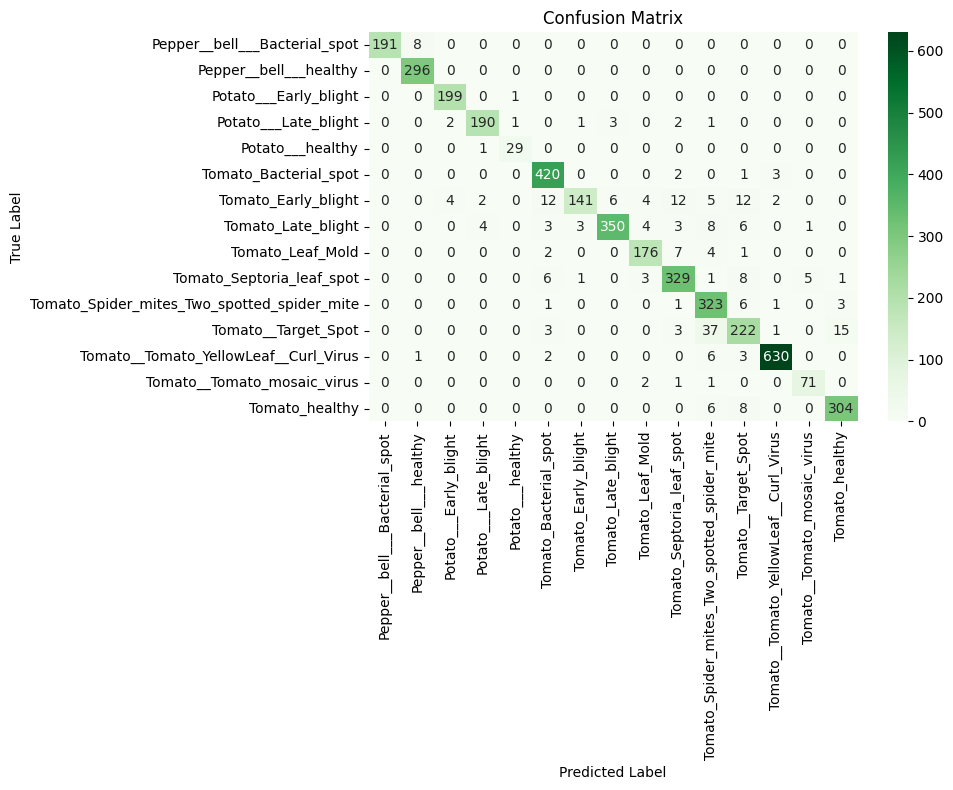

In [12]:
# 🔁 8. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [13]:
import random
from tensorflow.keras.utils import load_img, img_to_array

In [18]:
def predict_random_image(knn_model, class_names, X_train, y_train, image_paths, k=5):
    # Choose a random image
    random_idx = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[random_idx]
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))
    features = resnet(preprocessed).numpy()

    # Predict and get nearest neighbors
    pred_class = knn_model.predict(features)[0]
    pred_proba = knn_model.predict_proba(features)[0]
    confidence = np.max(pred_proba)
    
    neighbors = knn_model.kneighbors(features, return_distance=False)[0]
    neighbor_labels = y_train[neighbors]

    # Plot each image in its own row (test + k neighbors)
    plt.figure(figsize=(5, (k + 1) * 3))  # 1 image per row

    # Row 0: Test image
    plt.subplot(k + 1, 1, 1)
    plt.imshow(img)
    plt.axis('off')
    true_class = os.path.basename(os.path.dirname(image_path))
    plt.title(f"[Test Image]\nTrue: {true_class} | Pred: {class_names[pred_class]} | Conf: {confidence:.2f}")

    # Rows 1...k: Neighbors
    for i, neighbor_idx in enumerate(neighbors):
        neighbor_path = image_paths[neighbor_idx]
        neighbor_img = load_img(neighbor_path, target_size=img_size)
        label = y_train[neighbor_idx]

        plt.subplot(k + 1, 1, i + 2)
        plt.imshow(neighbor_img)
        plt.axis('off')
        plt.title(f"[Neighbor {i+1}] → Class: {class_names[label]}")

    plt.tight_layout()
    plt.show()

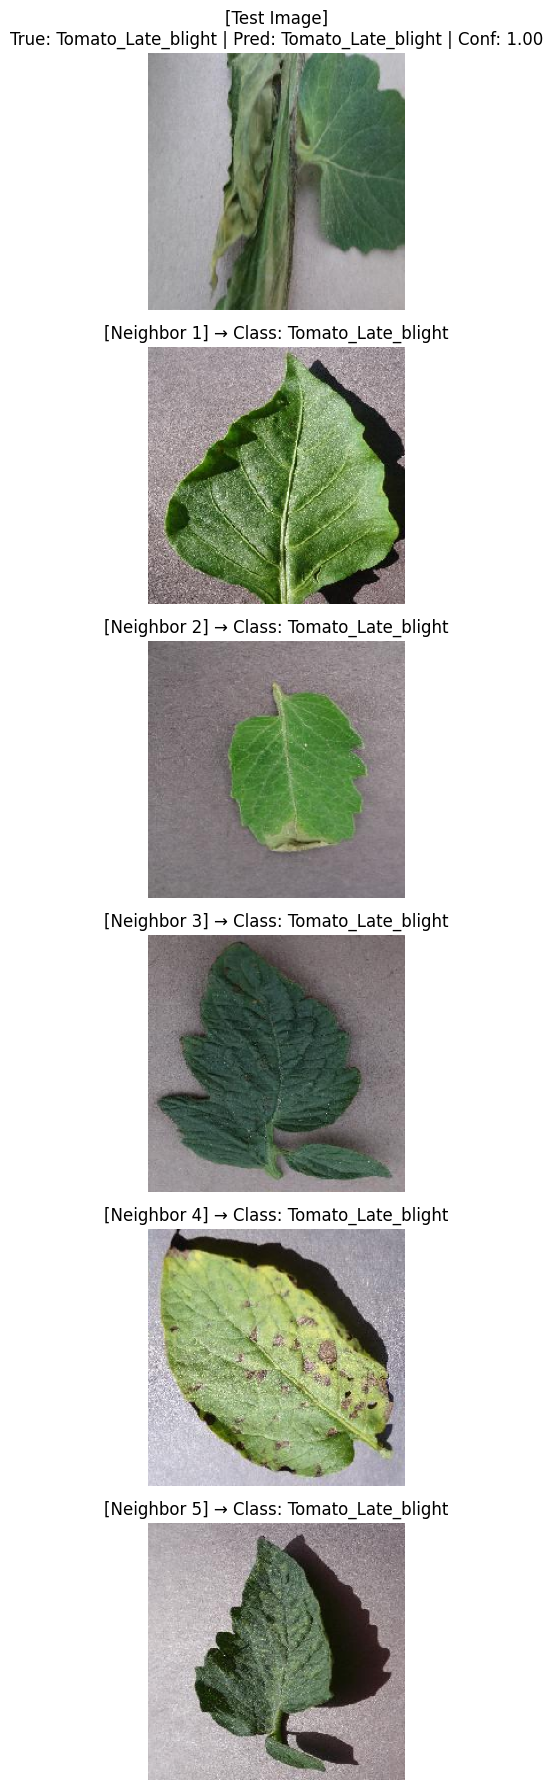

In [21]:
# ✅ Get list of file paths (assumes ../data/PlantVillage/<class_name>/<image>.jpg)
from pathlib import Path
dataset_root = Path("../data/PlantVillage")
image_paths = sorted([str(p) for p in dataset_root.glob("*/*.jpg")])

# 🔁 Call this cell multiple times to sample new predictions
predict_random_image(knn, class_names, X_train, y_train, image_paths, k=5)
